# VAE using PyTorch  

The purpose of this demo is to help you learn about variational autoencoder. The algorithm is being implemented is from the paper "Auto-Encoding Variational Bayes", by Diederik P Kingma, Max Welling (https://arxiv.org/abs/1312.6114). The code is mostly borrowed/referenced from https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/.

Followed the logic:
VAE: https://github.com/ethanluoyc/pytorch-vae/blob/master/vae.py 

VAE (debugger cafe): https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

You are free to change model acrhitecture, or any part of the logic. 

If you have any suggestions or find errors, please, don't be hesitate to email me at jayanta.jayantamukherjee@gmail.com

In the case of an autoencoder, we have 𝑧 as the latent vector. We sample 𝑝𝜃(𝑧) from 𝑧. Then we sample the reconstruction given 𝑧 as 𝑝𝜃(𝑥|𝑧). Here 𝜃 are the learned parameters.

We want to maximize the log-likelihood of the data. The marginal likelihood is composed of a sum over the marginal likelihoods of individual datapoints. That is,

𝑙𝑜𝑔𝑝𝜃(𝑥(1),…,𝑥(𝑁))=∑𝑖=1𝑁𝑙𝑜𝑔𝑝𝜃(𝑥(𝑖))

The variational lower bound is an important term.  

In [19]:
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F

## Linear VAE


In [20]:
features = 16
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        print("1 x shape = ", x.shape)
        x = F.relu(self.enc1(x))
        print("2 x shape = ", x.shape)
        x = self.enc2(x).view(-1, 2, features)
        print("3 x shape = ", x.shape)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        print("4 mu shape = ", mu.shape, ", log_var shape = ", log_var.shape)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        print("5 z shape = ", z.shape)
 
        # decoding
        x = F.relu(self.dec1(z))
        print("6 x shape = ", x.shape)
        reconstruction = torch.sigmoid(self.dec2(x))
        print("7 reconstruction shape = ", reconstruction.shape)
        return reconstruction, mu, log_var

## More Import

In [21]:
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

### Construct the Argument Parser and Define the Learning Parameters

In [22]:
# construct the argument parser and parser the arguments
parser = argparse.ArgumentParser()
parser.add_argument('-e', '--epochs', default=10, type=int, 
                    help='number of epochs to train the VAE for')
args, unknown = parser.parse_known_args()
#args = vars(parser.parse_args())

### Define Learning Parameters

In [23]:
# leanring parameters
epochs = args.epochs
batch_size = 64
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Preparing the MNIST Dataset 

In [24]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

### Train and Validation Data: loading MNIST 
If MNIST data is not there, this logic will download the MNIST dataset in ../data

In [25]:
# train and validation data
train_data = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

val_data = datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform=transform
)

### Define Train and Validation dataloader

In [26]:
# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

## Initializing the Linear VAE Model

In [27]:
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

### Define Final Loss Method

In [28]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### Define Training Method

In [35]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    train_data_len = len(train_data)
    total = int(len(train_data)/dataloader.batch_size)
    print("total = ", total)
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, _ = data
        print("2 data shape = ", data.shape)
        data = data.to(device)
        print("3 data shape = ", data.shape)
        data = data.view(data.size(0), -1)
        print("4 data shape = ", data.shape)
        optimizer.zero_grad()
        print("data shape = ", data.shape)
        reconstruction, mu, logvar = model(data)
        print("reconstruction shape = ", reconstruction.shape)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

### Define Validation Method

In [36]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

### Train & Eval

In [37]:
epochs = 10
train_loss = []
val_loss = []
RMS = []
train_epoch_durations = []
eval_epoch_durations = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    start_train_epoch = time.time()
    train_epoch_loss = fit(model, train_loader)
    end_train_epoch = time.time()
    train_epoch_duration = end_train_epoch - start_train_epoch
    train_epoch_durations.append(train_epoch_duration)

    val_epoch_loss = validate(model, val_loader)
    end_eval_epoch = time.time()
    eval_epoch_duration = end_eval_epoch - end_train_epoch
    eval_epoch_durations.append(eval_epoch_duration) 
    
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 10
total =  937


  1%|          | 10/937 [00:00<00:10, 91.56it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


  3%|▎         | 30/937 [00:00<00:09, 92.23it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


  5%|▌         | 50/937 [00:00<00:09, 92.41it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


  7%|▋         | 70/937 [00:00<00:09, 90.62it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 10%|▉         | 90/937 [00:00<00:09, 91.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 12%|█▏        | 110/937 [00:01<00:08, 91.94it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 14%|█▍        | 130/937 [00:01<00:08, 92.23it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 15%|█▍        | 140/937 [00:01<00:08, 92.08it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 16%|█▌        | 150/937 [00:01<00:08, 92.14it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 17%|█▋        | 160/937 [00:01<00:08, 92.23it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 19%|█▉        | 180/937 [00:01<00:08, 92.31it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 21%|██▏       | 200/937 [00:02<00:07, 92.24it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 23%|██▎       | 220/937 [00:02<00:07, 92.20it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 26%|██▌       | 240/937 [00:02<00:07, 92.12it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 28%|██▊       | 260/937 [00:02<00:07, 92.16it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 30%|██▉       | 280/937 [00:03<00:07, 92.13it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 32%|███▏      | 300/937 [00:03<00:06, 92.05it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 34%|███▍      | 320/937 [00:03<00:06, 91.93it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 35%|███▌      | 330/937 [00:03<00:06, 91.76it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 36%|███▋      | 340/937 [00:03<00:06, 91.73it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 37%|███▋      | 350/937 [00:03<00:06, 91.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 39%|███▉      | 370/937 [00:04<00:06, 91.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 42%|████▏     | 390/937 [00:04<00:05, 91.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 44%|████▍     | 410/937 [00:04<00:05, 91.86it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 46%|████▌     | 430/937 [00:04<00:05, 91.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 48%|████▊     | 450/937 [00:04<00:05, 91.75it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 50%|█████     | 470/937 [00:05<00:05, 91.75it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 52%|█████▏    | 490/937 [00:05<00:04, 91.83it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 54%|█████▍    | 510/937 [00:05<00:04, 91.76it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 55%|█████▌    | 520/937 [00:05<00:04, 91.61it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 57%|█████▋    | 530/937 [00:05<00:04, 91.65it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 58%|█████▊    | 540/937 [00:05<00:04, 93.22it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 59%|█████▊    | 550/937 [00:05<00:04, 94.38it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 60%|█████▉    | 560/937 [00:06<00:04, 93.21it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 62%|██████▏   | 580/937 [00:06<00:03, 93.74it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 64%|██████▍   | 600/937 [00:06<00:03, 94.07it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 66%|██████▌   | 620/937 [00:06<00:03, 94.20it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 68%|██████▊   | 640/937 [00:06<00:03, 90.86it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 70%|███████   | 660/937 [00:07<00:03, 92.16it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 73%|███████▎  | 680/937 [00:07<00:02, 92.98it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 75%|███████▍  | 700/937 [00:07<00:02, 93.25it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 77%|███████▋  | 720/937 [00:07<00:02, 93.45it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 78%|███████▊  | 730/937 [00:07<00:02, 93.33it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 79%|███████▉  | 740/937 [00:08<00:02, 93.43it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 80%|████████  | 750/937 [00:08<00:01, 93.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 82%|████████▏ | 770/937 [00:08<00:01, 93.65it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 84%|████████▍ | 790/937 [00:08<00:01, 93.56it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 86%|████████▋ | 810/937 [00:08<00:01, 92.89it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 89%|████████▊ | 830/937 [00:08<00:01, 92.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 91%|█████████ | 850/937 [00:09<00:00, 92.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 93%|█████████▎| 870/937 [00:09<00:00, 92.76it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 95%|█████████▍| 890/937 [00:09<00:00, 92.75it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 97%|█████████▋| 910/937 [00:09<00:00, 92.75it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 98%|█████████▊| 920/937 [00:09<00:00, 92.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 99%|█████████▉| 930/937 [00:10<00:00, 92.35it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


938it [00:10, 92.40it/s]                         


2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 10%|█         | 16/156 [00:00<00:00, 152.62it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 21%|██        | 32/156 [00:00<00:00, 150.69it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 31%|███       | 48/156 [00:00<00:00, 151.30it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 41%|████      | 64/156 [00:00<00:00, 151.05it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 51%|█████▏    | 80/156 [00:00<00:00, 151.31it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 62%|██████▏   | 96/156 [00:00<00:00, 151.28it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 72%|███████▏  | 112/156 [00:00<00:00, 151.17it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 82%|████████▏ | 128/156 [00:00<00:00, 151.48it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 92%|█████████▏| 144/156 [00:00<00:00, 151.29it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

157it [00:01, 151.54it/s]                         


1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([16, 784])
2 x shape =  torch.Size([16, 512])
3 x shape =  torch.Size([16, 2, 16])
4 mu shape =  torch.Size([16, 16]) , log_var shape =  torch.Size([16, 16])
5 z shape =  torch.Size([16, 16])
6 x shape =  torch.Size([16, 512])
7 reconstruction shape =  torch.Size([16, 784])
Train Loss: 112.7629
Val Loss: 111.3018
Epoch 2 of 10
total =  937


  0%|          | 0/937 [00:00<?, ?it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  1%|          | 9/937 [00:00<00:10, 89.94it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  2%|▏         | 18/937 [00:00<00:10, 86.78it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  3%|▎         | 28/937 [00:00<00:10, 88.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  4%|▍         | 37/937 [00:00<00:10, 89.07it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

  5%|▍         | 46/937 [00:00<00:09, 89.27it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

  6%|▌         | 55/937 [00:00<00:09, 89.38it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

  7%|▋         | 64/937 [00:00<00:09, 89.35it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

  8%|▊         | 73/937 [00:00<00:09, 89.42it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

  9%|▉         | 82/937 [00:00<00:09, 89.46it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 10%|▉         | 92/937 [00:01<00:09, 89.67it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 11%|█         | 101/937 [00:01<00:09, 89.52it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 12%|█▏        | 110/937 [00:01<00:09, 89.34it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 13%|█▎        | 119/937 [00:01<00:09, 89.12it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 14%|█▎        | 128/937 [00:01<00:09, 89.03it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 15%|█▍        | 137/937 [00:01<00:08, 88.95it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 16%|█▌        | 146/937 [00:01<00:08, 88.88it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 17%|█▋        | 155/937 [00:01<00:08, 88.92it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 18%|█▊        | 164/937 [00:01<00:08, 88.91it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 18%|█▊        | 173/937 [00:01<00:08, 88.85it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 19%|█▉        | 182/937 [00:02<00:08, 88.84it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 20%|██        | 191/937 [00:02<00:08, 85.41it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 21%|██▏       | 200/937 [00:02<00:08, 85.78it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 22%|██▏       | 209/937 [00:02<00:08, 86.17it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 23%|██▎       | 218/937 [00:02<00:08, 85.40it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 24%|██▍       | 227/937 [00:02<00:08, 83.47it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 25%|██▌       | 236/937 [00:02<00:08, 81.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 26%|██▌       | 245/937 [00:02<00:08, 80.79it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 27%|██▋       | 254/937 [00:02<00:08, 80.38it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 28%|██▊       | 263/937 [00:03<00:08, 79.89it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 29%|██▉       | 271/937 [00:03<00:08, 79.75it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 30%|██▉       | 280/937 [00:03<00:08, 80.51it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 31%|███       | 290/937 [00:03<00:07, 84.84it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 32%|███▏      | 300/937 [00:03<00:07, 87.92it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 33%|███▎      | 310/937 [00:03<00:06, 90.13it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 34%|███▍      | 320/937 [00:03<00:06, 91.64it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 35%|███▌      | 330/937 [00:03<00:06, 92.57it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 36%|███▋      | 340/937 [00:03<00:06, 91.02it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 37%|███▋      | 350/937 [00:04<00:06, 84.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 38%|███▊      | 360/937 [00:04<00:06, 87.63it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 39%|███▉      | 370/937 [00:04<00:06, 89.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 41%|████      | 380/937 [00:04<00:06, 91.45it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 42%|████▏     | 390/937 [00:04<00:05, 91.39it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 43%|████▎     | 400/937 [00:04<00:05, 91.28it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 44%|████▍     | 410/937 [00:04<00:05, 92.89it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 45%|████▍     | 420/937 [00:04<00:05, 93.81it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 46%|████▌     | 430/937 [00:04<00:05, 94.59it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 47%|████▋     | 440/937 [00:04<00:05, 95.13it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 48%|████▊     | 450/937 [00:05<00:05, 95.51it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 49%|████▉     | 460/937 [00:05<00:04, 95.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 50%|█████     | 470/937 [00:05<00:04, 94.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 51%|█████     | 480/937 [00:05<00:04, 94.04it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 52%|█████▏    | 490/937 [00:05<00:04, 93.37it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 53%|█████▎    | 500/937 [00:05<00:04, 94.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 54%|█████▍    | 510/937 [00:05<00:04, 93.50it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 55%|█████▌    | 520/937 [00:05<00:04, 92.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 57%|█████▋    | 530/937 [00:05<00:04, 93.83it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 58%|█████▊    | 540/937 [00:06<00:04, 92.52it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 59%|█████▊    | 550/937 [00:06<00:04, 93.59it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 60%|█████▉    | 560/937 [00:06<00:04, 92.49it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 61%|██████    | 570/937 [00:06<00:03, 92.43it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 62%|██████▏   | 580/937 [00:06<00:03, 92.17it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 63%|██████▎   | 590/937 [00:06<00:03, 91.38it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 64%|██████▍   | 600/937 [00:06<00:03, 92.33it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 65%|██████▌   | 610/937 [00:06<00:03, 93.61it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 66%|██████▌   | 620/937 [00:06<00:03, 94.33it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 67%|██████▋   | 630/937 [00:07<00:03, 94.96it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 68%|██████▊   | 640/937 [00:07<00:03, 95.35it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])


 69%|██████▉   | 650/937 [00:07<00:03, 95.30it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 70%|███████   | 660/937 [00:07<00:02, 95.19it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 72%|███████▏  | 670/937 [00:07<00:02, 95.11it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 73%|███████▎  | 680/937 [00:07<00:02, 95.14it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 74%|███████▎  | 690/937 [00:07<00:02, 95.11it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 75%|███████▍  | 700/937 [00:07<00:02, 95.17it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 76%|███████▌  | 710/937 [00:07<00:02, 95.19it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 77%|███████▋  | 720/937 [00:07<00:02, 95.25it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 78%|███████▊  | 730/937 [00:08<00:02, 95.27it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 79%|███████▉  | 740/937 [00:08<00:02, 95.29it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 80%|████████  | 750/937 [00:08<00:01, 95.22it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 81%|████████  | 760/937 [00:08<00:01, 95.34it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 82%|████████▏ | 770/937 [00:08<00:01, 95.41it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 83%|████████▎ | 780/937 [00:08<00:01, 95.36it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 84%|████████▍ | 790/937 [00:08<00:01, 95.34it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 85%|████████▌ | 800/937 [00:08<00:01, 95.31it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 86%|████████▋ | 810/937 [00:08<00:01, 95.36it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 88%|████████▊ | 820/937 [00:09<00:01, 95.44it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 89%|████████▊ | 830/937 [00:09<00:01, 95.41it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 90%|████████▉ | 840/937 [00:09<00:01, 95.43it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 91%|█████████ | 850/937 [00:09<00:00, 95.47it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 92%|█████████▏| 860/937 [00:09<00:00, 95.46it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 93%|█████████▎| 870/937 [00:09<00:00, 95.50it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 94%|█████████▍| 880/937 [00:09<00:00, 95.51it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 95%|█████████▍| 890/937 [00:09<00:00, 95.41it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 96%|█████████▌| 900/937 [00:09<00:00, 95.45it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 97%|█████████▋| 910/937 [00:09<00:00, 95.44it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 98%|█████████▊| 920/937 [00:10<00:00, 95.42it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 99%|█████████▉| 930/937 [00:10<00:00, 95.40it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

938it [00:10, 91.60it/s]                         


2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  0%|          | 0/156 [00:00<?, ?it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 10%|█         | 16/156 [00:00<00:00, 158.12it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 21%|██        | 32/156 [00:00<00:00, 157.87it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 31%|███       | 48/156 [00:00<00:00, 157.46it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 41%|████      | 64/156 [00:00<00:00, 157.58it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 51%|█████▏    | 80/156 [00:00<00:00, 157.42it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 62%|██████▏   | 96/156 [00:00<00:00, 157.48it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 72%|███████▏  | 112/156 [00:00<00:00, 157.40it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 82%|████████▏ | 128/156 [00:00<00:00, 157.52it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 92%|█████████▏| 144/156 [00:00<00:00, 157.37it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

157it [00:00, 157.74it/s]                         


1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

  0%|          | 0/937 [00:00<?, ?it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  1%|          | 10/937 [00:00<00:10, 89.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  2%|▏         | 19/937 [00:00<00:11, 80.86it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  3%|▎         | 28/937 [00:00<00:11, 80.03it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  4%|▍         | 37/937 [00:00<00:11, 79.42it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  5%|▍         | 45/937 [00:00<00:11, 79.12it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  6%|▌         | 53/937 [00:00<00:11, 78.70it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  7%|▋         | 61/937 [00:00<00:11, 77.55it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  7%|▋         | 69/937 [00:00<00:11, 76.96it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

  8%|▊         | 77/937 [00:00<00:11, 76.34it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

  9%|▉         | 85/937 [00:01<00:11, 75.72it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 10%|▉         | 93/937 [00:01<00:11, 75.43it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 11%|█         | 101/937 [00:01<00:10, 76.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 12%|█▏        | 109/937 [00:01<00:10, 77.21it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 12%|█▏        | 117/937 [00:01<00:10, 77.59it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 13%|█▎        | 125/937 [00:01<00:10, 78.02it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 14%|█▍        | 133/937 [00:01<00:10, 77.68it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 15%|█▌        | 141/937 [00:01<00:10, 77.52it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 16%|█▌        | 149/937 [00:01<00:10, 78.24it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 17%|█▋        | 157/937 [00:02<00:10, 74.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 18%|█▊        | 165/937 [00:02<00:10, 72.11it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 19%|█▊        | 174/937 [00:02<00:09, 76.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 20%|█▉        | 183/937 [00:02<00:09, 79.06it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 21%|██        | 193/937 [00:02<00:09, 82.65it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 22%|██▏       | 202/937 [00:02<00:08, 81.86it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 23%|██▎       | 211/937 [00:02<00:08, 80.86it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 23%|██▎       | 220/937 [00:02<00:08, 80.09it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 24%|██▍       | 229/937 [00:02<00:08, 79.48it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 25%|██▌       | 237/937 [00:03<00:08, 79.42it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 26%|██▌       | 245/937 [00:03<00:08, 79.29it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 27%|██▋       | 253/937 [00:03<00:08, 79.41it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 28%|██▊       | 261/937 [00:03<00:08, 77.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 29%|██▊       | 269/937 [00:03<00:08, 78.24it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 30%|██▉       | 277/937 [00:03<00:08, 78.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 30%|███       | 285/937 [00:03<00:08, 78.91it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 31%|███▏      | 293/937 [00:03<00:08, 78.72it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 32%|███▏      | 301/937 [00:03<00:08, 78.55it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 33%|███▎      | 309/937 [00:03<00:08, 78.28it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 34%|███▍      | 317/937 [00:04<00:07, 78.25it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 35%|███▍      | 325/937 [00:04<00:07, 78.10it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 36%|███▌      | 333/937 [00:04<00:07, 77.45it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 36%|███▋      | 341/937 [00:04<00:07, 77.15it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 37%|███▋      | 350/937 [00:04<00:07, 78.33it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 38%|███▊      | 360/937 [00:04<00:07, 82.16it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 39%|███▉      | 370/937 [00:04<00:06, 85.34it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 41%|████      | 380/937 [00:04<00:06, 87.59it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 42%|████▏     | 390/937 [00:04<00:06, 89.50it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 43%|████▎     | 399/937 [00:05<00:06, 88.35it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 44%|████▎     | 408/937 [00:05<00:06, 87.71it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 45%|████▍     | 417/937 [00:05<00:05, 88.16it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 45%|████▌     | 426/937 [00:05<00:05, 88.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 46%|████▋     | 435/937 [00:05<00:05, 88.51it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 47%|████▋     | 444/937 [00:05<00:05, 88.78it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 48%|████▊     | 453/937 [00:05<00:05, 88.78it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 49%|████▉     | 462/937 [00:05<00:05, 88.97it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 50%|█████     | 471/937 [00:05<00:05, 88.90it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 51%|█████     | 480/937 [00:05<00:05, 88.99it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 52%|█████▏    | 489/937 [00:06<00:05, 88.94it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 53%|█████▎    | 498/937 [00:06<00:04, 89.09it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 54%|█████▍    | 507/937 [00:06<00:04, 88.99it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 55%|█████▌    | 516/937 [00:06<00:04, 89.09it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 56%|█████▌    | 525/937 [00:06<00:04, 88.97it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 57%|█████▋    | 534/937 [00:06<00:04, 89.01it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 58%|█████▊    | 543/937 [00:06<00:04, 88.95it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 59%|█████▉    | 552/937 [00:06<00:04, 89.09it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 60%|█████▉    | 561/937 [00:06<00:04, 88.97it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 61%|██████    | 570/937 [00:06<00:04, 88.99it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 62%|██████▏   | 579/937 [00:07<00:04, 88.94it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 63%|██████▎   | 588/937 [00:07<00:03, 89.13it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 64%|██████▎   | 597/937 [00:07<00:03, 89.07it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 65%|██████▍   | 606/937 [00:07<00:03, 89.23it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 66%|██████▌   | 615/937 [00:07<00:03, 89.00it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 67%|██████▋   | 624/937 [00:07<00:03, 89.11it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 68%|██████▊   | 633/937 [00:07<00:03, 89.02it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 69%|██████▊   | 642/937 [00:07<00:03, 89.07it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 69%|██████▉   | 651/937 [00:07<00:03, 88.93it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 70%|███████   | 660/937 [00:07<00:03, 89.02it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 71%|███████▏  | 669/937 [00:08<00:03, 88.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 72%|███████▏  | 678/937 [00:08<00:02, 89.05it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 73%|███████▎  | 687/937 [00:08<00:02, 88.97it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 74%|███████▍  | 697/937 [00:08<00:02, 89.44it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 75%|███████▌  | 707/937 [00:08<00:02, 90.52it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 77%|███████▋  | 717/937 [00:08<00:02, 91.17it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 78%|███████▊  | 727/937 [00:08<00:02, 91.92it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 79%|███████▊  | 737/937 [00:08<00:02, 92.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 80%|███████▉  | 747/937 [00:08<00:02, 92.50it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 81%|████████  | 757/937 [00:09<00:01, 92.75it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 82%|████████▏ | 767/937 [00:09<00:01, 92.94it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 83%|████████▎ | 777/937 [00:09<00:01, 92.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 84%|████████▍ | 787/937 [00:09<00:01, 93.07it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 85%|████████▌ | 797/937 [00:09<00:01, 93.26it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 86%|████████▌ | 807/937 [00:09<00:01, 93.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 87%|████████▋ | 817/937 [00:09<00:01, 93.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 88%|████████▊ | 827/937 [00:09<00:01, 93.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 89%|████████▉ | 837/937 [00:09<00:01, 93.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 90%|█████████ | 847/937 [00:09<00:00, 94.11it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 91%|█████████▏| 857/937 [00:10<00:00, 94.01it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 93%|█████████▎| 867/937 [00:10<00:00, 91.80it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 94%|█████████▎| 877/937 [00:10<00:00, 92.60it/s]

data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Si

 95%|█████████▍| 887/937 [00:10<00:00, 91.81it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 96%|█████████▌| 897/937 [00:10<00:00, 89.88it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 97%|█████████▋| 907/937 [00:10<00:00, 91.16it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 98%|█████████▊| 917/937 [00:10<00:00, 90.33it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 99%|█████████▉| 927/937 [00:10<00:00, 91.37it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

938it [00:10, 85.61it/s]                         


3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

  0%|          | 0/156 [00:00<?, ?it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 10%|▉         | 15/156 [00:00<00:00, 142.41it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 20%|█▉        | 31/156 [00:00<00:00, 150.00it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.S

 30%|███       | 47/156 [00:00<00:00, 147.92it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 1

 40%|████      | 63/156 [00:00<00:00, 149.89it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 50%|█████     | 78/156 [00:00<00:00, 144.43it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 60%|█████▉    | 93/156 [00:00<00:00, 144.63it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.S

 70%|██████▉   | 109/156 [00:00<00:00, 148.44it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 80%|████████  | 125/156 [00:00<00:00, 150.36it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 90%|█████████ | 141/156 [00:00<00:00, 148.56it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

157it [00:01, 148.73it/s]                         


6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([16, 784])
2 x shape =  torch.Size([16, 512])
3 x shape =  torch.Size([16, 2, 16])
4 mu shape =  torch.Size([16, 16]) , log_var shape =  torch.Size([16, 16])
5 z shape =  torch.Size([16, 16])
6 x shape =  torch.Size([16, 512])
7 reconstruction shape =  torch.Size([16, 784])
Train Loss: 111.3164
Val Loss: 110.1261
Epoch 4 of 10
total =  937


  0%|          | 0/937 [00:00<?, ?it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  1%|          | 9/937 [00:00<00:10, 86.40it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  2%|▏         | 18/937 [00:00<00:10, 88.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  3%|▎         | 27/937 [00:00<00:10, 88.90it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  4%|▍         | 36/937 [00:00<00:10, 84.46it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  5%|▍         | 45/937 [00:00<00:10, 83.06it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

  6%|▌         | 54/937 [00:00<00:10, 81.33it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  7%|▋         | 63/937 [00:00<00:10, 81.49it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  8%|▊         | 72/937 [00:00<00:10, 81.16it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  9%|▊         | 81/937 [00:00<00:10, 83.23it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 10%|▉         | 90/937 [00:01<00:10, 82.73it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 11%|█         | 99/937 [00:01<00:09, 84.55it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 12%|█▏        | 108/937 [00:01<00:09, 85.34it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 12%|█▏        | 117/937 [00:01<00:09, 85.92it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 13%|█▎        | 126/937 [00:01<00:09, 86.02it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 14%|█▍        | 135/937 [00:01<00:09, 86.38it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 15%|█▌        | 144/937 [00:01<00:10, 78.76it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 16%|█▋        | 153/937 [00:01<00:10, 75.30it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 17%|█▋        | 161/937 [00:01<00:10, 73.17it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 18%|█▊        | 169/937 [00:02<00:10, 71.50it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 19%|█▉        | 177/937 [00:02<00:10, 70.25it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 20%|█▉        | 185/937 [00:02<00:10, 69.40it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 20%|██        | 192/937 [00:02<00:10, 68.55it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 21%|██        | 199/937 [00:02<00:10, 68.05it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 22%|██▏       | 206/937 [00:02<00:10, 67.62it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 23%|██▎       | 213/937 [00:02<00:10, 67.49it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 23%|██▎       | 220/937 [00:02<00:10, 67.30it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 24%|██▍       | 228/937 [00:02<00:10, 69.32it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 25%|██▌       | 236/937 [00:03<00:09, 71.57it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 26%|██▌       | 244/937 [00:03<00:09, 73.37it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 27%|██▋       | 252/937 [00:03<00:09, 74.52it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 28%|██▊       | 260/937 [00:03<00:08, 75.48it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 29%|██▊       | 268/937 [00:03<00:08, 76.09it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 29%|██▉       | 276/937 [00:03<00:08, 76.89it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 30%|███       | 284/937 [00:03<00:08, 77.11it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 31%|███       | 292/937 [00:03<00:08, 77.42it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 32%|███▏      | 300/937 [00:03<00:08, 77.70it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 33%|███▎      | 308/937 [00:03<00:08, 78.04it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 34%|███▎      | 316/937 [00:04<00:07, 78.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 35%|███▍      | 324/937 [00:04<00:07, 78.39it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 35%|███▌      | 332/937 [00:04<00:07, 78.46it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 36%|███▋      | 340/937 [00:04<00:07, 78.68it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 37%|███▋      | 348/937 [00:04<00:07, 78.83it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 38%|███▊      | 356/937 [00:04<00:07, 78.90it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 39%|███▉      | 364/937 [00:04<00:07, 78.25it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 40%|███▉      | 373/937 [00:04<00:07, 79.43it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 41%|████      | 382/937 [00:04<00:06, 81.38it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 42%|████▏     | 392/937 [00:05<00:06, 84.48it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 43%|████▎     | 402/937 [00:05<00:06, 87.37it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 44%|████▍     | 412/937 [00:05<00:05, 89.48it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 45%|████▌     | 422/937 [00:05<00:05, 90.24it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 46%|████▌     | 432/937 [00:05<00:05, 90.37it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 47%|████▋     | 442/937 [00:05<00:05, 90.40it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 48%|████▊     | 452/937 [00:05<00:05, 90.41it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 49%|████▉     | 462/937 [00:05<00:05, 90.40it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 50%|█████     | 472/937 [00:05<00:05, 90.48it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 51%|█████▏    | 482/937 [00:06<00:05, 90.53it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 53%|█████▎    | 492/937 [00:06<00:04, 90.52it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 54%|█████▎    | 502/937 [00:06<00:04, 90.52it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 55%|█████▍    | 512/937 [00:06<00:04, 90.45it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 56%|█████▌    | 522/937 [00:06<00:04, 90.54it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 57%|█████▋    | 532/937 [00:06<00:04, 90.26it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 58%|█████▊    | 542/937 [00:06<00:04, 90.44it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 59%|█████▉    | 552/937 [00:06<00:04, 90.36it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 60%|█████▉    | 562/937 [00:06<00:04, 90.48it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 61%|██████    | 572/937 [00:07<00:04, 90.39it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 62%|██████▏   | 582/937 [00:07<00:03, 90.43it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 63%|██████▎   | 592/937 [00:07<00:03, 90.50it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 64%|██████▍   | 602/937 [00:07<00:03, 90.63it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 65%|██████▌   | 612/937 [00:07<00:03, 90.60it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 66%|██████▋   | 622/937 [00:07<00:03, 90.43it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 67%|██████▋   | 632/937 [00:07<00:03, 90.59it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 69%|██████▊   | 642/937 [00:07<00:03, 90.49it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 70%|██████▉   | 652/937 [00:07<00:03, 90.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 71%|███████   | 662/937 [00:08<00:03, 90.52it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 72%|███████▏  | 672/937 [00:08<00:02, 90.70it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 73%|███████▎  | 682/937 [00:08<00:02, 90.55it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 74%|███████▍  | 692/937 [00:08<00:02, 90.49it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 75%|███████▍  | 702/937 [00:08<00:02, 90.53it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 76%|███████▌  | 712/937 [00:08<00:02, 90.63it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 77%|███████▋  | 722/937 [00:08<00:02, 90.64it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 78%|███████▊  | 732/937 [00:08<00:02, 90.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 79%|███████▉  | 742/937 [00:08<00:02, 90.52it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 80%|████████  | 752/937 [00:09<00:02, 90.47it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 81%|████████▏ | 762/937 [00:09<00:01, 90.53it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 82%|████████▏ | 772/937 [00:09<00:01, 90.17it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 83%|████████▎ | 782/937 [00:09<00:01, 89.86it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 85%|████████▍ | 792/937 [00:09<00:01, 90.40it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 86%|████████▌ | 802/937 [00:09<00:01, 91.41it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 87%|████████▋ | 812/937 [00:09<00:01, 91.71it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 88%|████████▊ | 822/937 [00:09<00:01, 91.89it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 89%|████████▉ | 832/937 [00:09<00:01, 90.98it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 90%|████████▉ | 842/937 [00:09<00:01, 91.79it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 91%|█████████ | 852/937 [00:10<00:00, 92.36it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 92%|█████████▏| 862/937 [00:10<00:00, 90.86it/s]

data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Si

 93%|█████████▎| 872/937 [00:10<00:00, 91.87it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 94%|█████████▍| 882/937 [00:10<00:00, 90.02it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 95%|█████████▌| 892/937 [00:10<00:00, 91.43it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 96%|█████████▋| 902/937 [00:10<00:00, 91.61it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 97%|█████████▋| 912/937 [00:10<00:00, 90.22it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 98%|█████████▊| 922/937 [00:10<00:00, 91.09it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 99%|█████████▉| 932/937 [00:10<00:00, 92.00it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

938it [00:11, 84.94it/s]                         
  0%|          | 0/156 [00:00<?, ?it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 10%|█         | 16/156 [00:00<00:00, 157.59it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 1

 21%|██        | 32/156 [00:00<00:00, 157.08it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 31%|███       | 48/156 [00:00<00:00, 152.59it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 41%|████      | 64/156 [00:00<00:00, 154.30it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 51%|█████▏    | 80/156 [00:00<00:00, 151.51it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 62%|██████▏   | 96/156 [00:00<00:00, 153.43it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 72%|███████▏  | 112/156 [00:00<00:00, 155.04it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 82%|████████▏ | 128/156 [00:00<00:00, 151.89it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 92%|█████████▏| 144/156 [00:00<00:00, 153.84it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

157it [00:01, 153.62it/s]                         


2 x shape =  torch.Size([16, 512])
3 x shape =  torch.Size([16, 2, 16])
4 mu shape =  torch.Size([16, 16]) , log_var shape =  torch.Size([16, 16])
5 z shape =  torch.Size([16, 16])
6 x shape =  torch.Size([16, 512])
7 reconstruction shape =  torch.Size([16, 784])
Train Loss: 110.7341
Val Loss: 109.6242
Epoch 5 of 10
total =  937


  0%|          | 0/937 [00:00<?, ?it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  1%|          | 9/937 [00:00<00:10, 88.81it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  2%|▏         | 18/937 [00:00<00:10, 84.81it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  3%|▎         | 27/937 [00:00<00:11, 79.78it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  4%|▍         | 36/937 [00:00<00:11, 79.35it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

  5%|▍         | 45/937 [00:00<00:11, 79.90it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

  6%|▌         | 54/937 [00:00<00:11, 78.52it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  7%|▋         | 62/937 [00:00<00:11, 74.92it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  7%|▋         | 70/937 [00:00<00:11, 72.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  8%|▊         | 78/937 [00:01<00:12, 70.59it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  9%|▉         | 86/937 [00:01<00:12, 69.30it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 10%|█         | 94/937 [00:01<00:12, 70.19it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 11%|█         | 102/937 [00:01<00:12, 69.50it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 12%|█▏        | 111/937 [00:01<00:11, 73.48it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 13%|█▎        | 120/937 [00:01<00:10, 76.90it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 14%|█▎        | 128/937 [00:01<00:10, 73.64it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 15%|█▍        | 136/937 [00:01<00:11, 71.75it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 15%|█▌        | 144/937 [00:01<00:11, 70.34it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 16%|█▌        | 152/937 [00:02<00:11, 69.48it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 17%|█▋        | 159/937 [00:02<00:11, 69.00it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 18%|█▊        | 166/937 [00:02<00:11, 68.56it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 19%|█▊        | 174/937 [00:02<00:10, 70.51it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 19%|█▉        | 182/937 [00:02<00:10, 71.27it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 20%|██        | 191/937 [00:02<00:09, 75.00it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 21%|██        | 199/937 [00:02<00:09, 75.78it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 22%|██▏       | 208/937 [00:02<00:09, 78.44it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 23%|██▎       | 218/937 [00:02<00:08, 82.45it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 24%|██▍       | 228/937 [00:03<00:08, 85.93it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 25%|██▌       | 237/937 [00:03<00:08, 85.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 26%|██▋       | 247/937 [00:03<00:07, 88.18it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 27%|██▋       | 257/937 [00:03<00:07, 89.76it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 28%|██▊       | 267/937 [00:03<00:07, 90.91it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 30%|██▉       | 277/937 [00:03<00:07, 91.68it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 31%|███       | 287/937 [00:03<00:07, 92.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 32%|███▏      | 297/937 [00:03<00:06, 92.52it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 33%|███▎      | 307/937 [00:03<00:06, 92.74it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 34%|███▍      | 317/937 [00:03<00:06, 92.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 35%|███▍      | 327/937 [00:04<00:06, 89.53it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 36%|███▌      | 337/937 [00:04<00:06, 90.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 37%|███▋      | 347/937 [00:04<00:06, 91.13it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 38%|███▊      | 357/937 [00:04<00:06, 91.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 39%|███▉      | 367/937 [00:04<00:06, 91.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 40%|████      | 377/937 [00:04<00:06, 92.16it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 41%|████▏     | 387/937 [00:04<00:05, 92.13it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 42%|████▏     | 397/937 [00:04<00:05, 92.33it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 43%|████▎     | 407/937 [00:04<00:05, 92.39it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 45%|████▍     | 417/937 [00:05<00:05, 92.51it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 46%|████▌     | 427/937 [00:05<00:05, 92.47it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 47%|████▋     | 437/937 [00:05<00:05, 92.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 48%|████▊     | 447/937 [00:05<00:05, 92.42it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 49%|████▉     | 457/937 [00:05<00:05, 92.47it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 50%|████▉     | 467/937 [00:05<00:05, 91.95it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 51%|█████     | 477/937 [00:05<00:05, 91.88it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 52%|█████▏    | 487/937 [00:05<00:04, 91.68it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 53%|█████▎    | 497/937 [00:05<00:04, 91.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 54%|█████▍    | 507/937 [00:06<00:04, 91.64it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 55%|█████▌    | 517/937 [00:06<00:04, 91.41it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 56%|█████▌    | 527/937 [00:06<00:04, 91.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 57%|█████▋    | 537/937 [00:06<00:04, 91.42it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 58%|█████▊    | 547/937 [00:06<00:04, 91.45it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 59%|█████▉    | 557/937 [00:06<00:04, 91.21it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 61%|██████    | 567/937 [00:06<00:04, 89.68it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 62%|██████▏   | 577/937 [00:06<00:03, 90.23it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 63%|██████▎   | 587/937 [00:06<00:03, 88.99it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 64%|██████▎   | 596/937 [00:07<00:03, 86.94it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 65%|██████▍   | 605/937 [00:07<00:03, 85.73it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 66%|██████▌   | 615/937 [00:07<00:03, 86.97it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 67%|██████▋   | 625/937 [00:07<00:03, 88.05it/s]

data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Si

 68%|██████▊   | 635/937 [00:07<00:03, 88.75it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 69%|██████▉   | 645/937 [00:07<00:03, 89.24it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 70%|██████▉   | 655/937 [00:07<00:03, 89.66it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 71%|███████   | 665/937 [00:07<00:03, 89.74it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 72%|███████▏  | 675/937 [00:07<00:02, 90.00it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 73%|███████▎  | 685/937 [00:08<00:02, 90.17it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 74%|███████▍  | 695/937 [00:08<00:02, 90.25it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 75%|███████▌  | 705/937 [00:08<00:02, 90.28it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 76%|███████▋  | 715/937 [00:08<00:02, 90.26it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 77%|███████▋  | 725/937 [00:08<00:02, 90.51it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 78%|███████▊  | 735/937 [00:08<00:02, 90.64it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 80%|███████▉  | 745/937 [00:08<00:02, 89.95it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 81%|████████  | 755/937 [00:08<00:01, 91.22it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 82%|████████▏ | 765/937 [00:08<00:01, 91.94it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 83%|████████▎ | 775/937 [00:09<00:01, 92.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 84%|████████▍ | 785/937 [00:09<00:01, 92.93it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 85%|████████▍ | 795/937 [00:09<00:01, 92.76it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 86%|████████▌ | 805/937 [00:09<00:01, 93.17it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 87%|████████▋ | 815/937 [00:09<00:01, 92.70it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 88%|████████▊ | 825/937 [00:09<00:01, 93.00it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 89%|████████▉ | 835/937 [00:09<00:01, 93.45it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 90%|█████████ | 845/937 [00:09<00:00, 94.06it/s]

data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Si

 91%|█████████ | 855/937 [00:09<00:00, 93.97it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 92%|█████████▏| 865/937 [00:09<00:00, 94.47it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 93%|█████████▎| 875/937 [00:10<00:00, 94.79it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 94%|█████████▍| 885/937 [00:10<00:00, 94.68it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 96%|█████████▌| 895/937 [00:10<00:00, 94.79it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 97%|█████████▋| 905/937 [00:10<00:00, 94.69it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 98%|█████████▊| 915/937 [00:10<00:00, 94.91it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 99%|█████████▊| 925/937 [00:10<00:00, 95.06it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

938it [00:10, 87.16it/s]                         


2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  0%|          | 0/156 [00:00<?, ?it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 10%|█         | 16/156 [00:00<00:00, 157.79it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 21%|██        | 32/156 [00:00<00:00, 158.09it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 31%|███       | 48/156 [00:00<00:00, 157.99it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 41%|████      | 64/156 [00:00<00:00, 158.51it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 51%|█████▏    | 80/156 [00:00<00:00, 157.84it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 62%|██████▏   | 96/156 [00:00<00:00, 158.16it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 72%|███████▏  | 112/156 [00:00<00:00, 157.65it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 82%|████████▏ | 128/156 [00:00<00:00, 158.21it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 92%|█████████▏| 144/156 [00:00<00:00, 157.96it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

157it [00:00, 158.32it/s]                         


1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([16, 784])
2 x shape =  torch.Size([16, 512])
3 x shape =  torch.Size([16, 2, 16])
4 mu shape =  torch.Size([16, 16]) , log_var shape =  torch.Size([16, 16])
5 z shape =  torch.Size([16, 16])
6 x shape =  torch.Size([16, 512])
7 reconstruction shape =  torch.Size([16, 784])
Train Loss: 110.2696
Val Loss: 109.1976
Epoch 6 of 10
total =  937


  0%|          | 0/937 [00:00<?, ?it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  1%|          | 10/937 [00:00<00:10, 89.86it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  2%|▏         | 19/937 [00:00<00:11, 76.72it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  3%|▎         | 27/937 [00:00<00:12, 73.32it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  4%|▎         | 35/937 [00:00<00:12, 74.90it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  5%|▍         | 44/937 [00:00<00:11, 79.45it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  6%|▌         | 53/937 [00:00<00:10, 82.43it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  7%|▋         | 62/937 [00:00<00:10, 84.36it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  8%|▊         | 71/937 [00:00<00:10, 82.65it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  9%|▊         | 80/937 [00:00<00:10, 81.70it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  9%|▉         | 89/937 [00:01<00:10, 83.06it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 10%|█         | 98/937 [00:01<00:10, 81.00it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 11%|█▏        | 107/937 [00:01<00:10, 76.94it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 12%|█▏        | 115/937 [00:01<00:11, 74.60it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 13%|█▎        | 123/937 [00:01<00:11, 72.83it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 14%|█▍        | 131/937 [00:01<00:11, 71.73it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 15%|█▍        | 139/937 [00:01<00:11, 70.81it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 16%|█▌        | 147/937 [00:01<00:11, 70.19it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 17%|█▋        | 155/937 [00:02<00:11, 69.75it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 17%|█▋        | 162/937 [00:02<00:11, 69.47it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 18%|█▊        | 169/937 [00:02<00:11, 69.19it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 19%|█▉        | 176/937 [00:02<00:11, 69.10it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 20%|█▉        | 183/937 [00:02<00:10, 68.91it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 20%|██        | 191/937 [00:02<00:10, 71.27it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 21%|██▏       | 200/937 [00:02<00:09, 76.24it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 22%|██▏       | 209/937 [00:02<00:09, 79.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 23%|██▎       | 218/937 [00:02<00:08, 82.35it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 24%|██▍       | 227/937 [00:02<00:08, 81.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 25%|██▌       | 236/937 [00:03<00:08, 81.38it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 26%|██▌       | 245/937 [00:03<00:08, 79.68it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 27%|██▋       | 253/937 [00:03<00:08, 78.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 28%|██▊       | 261/937 [00:03<00:08, 78.14it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 29%|██▊       | 269/937 [00:03<00:08, 77.68it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 30%|██▉       | 277/937 [00:03<00:08, 77.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 30%|███       | 285/937 [00:03<00:08, 78.17it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 31%|███▏      | 293/937 [00:03<00:08, 78.07it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 32%|███▏      | 301/937 [00:03<00:08, 77.63it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 33%|███▎      | 309/937 [00:04<00:08, 77.38it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 34%|███▍      | 317/937 [00:04<00:08, 77.32it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 35%|███▍      | 325/937 [00:04<00:07, 77.26it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 36%|███▌      | 333/937 [00:04<00:07, 77.26it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 36%|███▋      | 341/937 [00:04<00:07, 77.16it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 37%|███▋      | 349/937 [00:04<00:07, 77.07it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 38%|███▊      | 357/937 [00:04<00:07, 77.00it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 39%|███▉      | 366/937 [00:04<00:07, 79.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 40%|████      | 375/937 [00:04<00:06, 81.01it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 41%|████      | 384/937 [00:04<00:07, 77.22it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 42%|████▏     | 392/937 [00:05<00:07, 74.36it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 43%|████▎     | 400/937 [00:05<00:07, 72.07it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 44%|████▎     | 408/937 [00:05<00:07, 70.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 44%|████▍     | 416/937 [00:05<00:07, 72.91it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 45%|████▌     | 426/937 [00:05<00:06, 78.86it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 47%|████▋     | 436/937 [00:05<00:06, 83.25it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 47%|████▋     | 445/937 [00:05<00:05, 84.51it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 49%|████▊     | 455/937 [00:05<00:05, 87.59it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 50%|████▉     | 465/937 [00:05<00:05, 90.06it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 51%|█████     | 475/937 [00:06<00:05, 91.43it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 52%|█████▏    | 485/937 [00:06<00:04, 92.72it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 53%|█████▎    | 495/937 [00:06<00:04, 93.47it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 54%|█████▍    | 505/937 [00:06<00:04, 94.04it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 55%|█████▍    | 515/937 [00:06<00:04, 94.46it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 56%|█████▌    | 525/937 [00:06<00:04, 94.71it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 57%|█████▋    | 535/937 [00:06<00:04, 94.90it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 58%|█████▊    | 545/937 [00:06<00:04, 95.03it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 59%|█████▉    | 555/937 [00:06<00:04, 95.24it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 60%|██████    | 565/937 [00:07<00:03, 95.15it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 61%|██████▏   | 575/937 [00:07<00:03, 95.34it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 62%|██████▏   | 585/937 [00:07<00:03, 95.20it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 64%|██████▎   | 595/937 [00:07<00:03, 95.45it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 65%|██████▍   | 605/937 [00:07<00:03, 95.31it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 66%|██████▌   | 615/937 [00:07<00:03, 95.39it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 67%|██████▋   | 625/937 [00:07<00:03, 95.25it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 68%|██████▊   | 635/937 [00:07<00:03, 95.52it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 69%|██████▉   | 645/937 [00:07<00:03, 95.36it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 70%|██████▉   | 655/937 [00:07<00:02, 95.51it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 71%|███████   | 665/937 [00:08<00:02, 95.38it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 72%|███████▏  | 675/937 [00:08<00:02, 95.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 73%|███████▎  | 685/937 [00:08<00:02, 95.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 74%|███████▍  | 695/937 [00:08<00:02, 95.66it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 75%|███████▌  | 705/937 [00:08<00:02, 95.70it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 76%|███████▋  | 715/937 [00:08<00:02, 95.67it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 77%|███████▋  | 725/937 [00:08<00:02, 95.59it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 78%|███████▊  | 735/937 [00:08<00:02, 95.61it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 80%|███████▉  | 745/937 [00:08<00:02, 95.67it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 81%|████████  | 755/937 [00:09<00:01, 95.74it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 82%|████████▏ | 765/937 [00:09<00:01, 95.55it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 83%|████████▎ | 775/937 [00:09<00:01, 95.67it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 84%|████████▍ | 785/937 [00:09<00:01, 95.67it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 85%|████████▍ | 795/937 [00:09<00:01, 95.76it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 86%|████████▌ | 805/937 [00:09<00:01, 95.66it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 87%|████████▋ | 815/937 [00:09<00:01, 95.44it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 88%|████████▊ | 825/937 [00:09<00:01, 94.96it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 89%|████████▉ | 835/937 [00:09<00:01, 94.77it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 90%|█████████ | 845/937 [00:09<00:00, 94.68it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 91%|█████████ | 855/937 [00:10<00:00, 94.60it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 92%|█████████▏| 865/937 [00:10<00:00, 94.47it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 93%|█████████▎| 875/937 [00:10<00:00, 94.31it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 94%|█████████▍| 885/937 [00:10<00:00, 94.34it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 96%|█████████▌| 895/937 [00:10<00:00, 94.26it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 97%|█████████▋| 905/937 [00:10<00:00, 94.31it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 98%|█████████▊| 915/937 [00:10<00:00, 94.27it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 99%|█████████▊| 925/937 [00:10<00:00, 94.31it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

100%|█████████▉| 935/937 [00:10<00:00, 94.27it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

938it [00:10, 85.70it/s]                         


data shape =  torch.Size([32, 784])
1 x shape =  torch.Size([32, 784])
2 x shape =  torch.Size([32, 512])
3 x shape =  torch.Size([32, 2, 16])
4 mu shape =  torch.Size([32, 16]) , log_var shape =  torch.Size([32, 16])
5 z shape =  torch.Size([32, 16])
6 x shape =  torch.Size([32, 512])
7 reconstruction shape =  torch.Size([32, 784])
reconstruction shape =  torch.Size([32, 784])


  0%|          | 0/156 [00:00<?, ?it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 10%|█         | 16/156 [00:00<00:00, 156.84it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 21%|██        | 32/156 [00:00<00:00, 156.36it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 31%|███       | 48/156 [00:00<00:00, 156.35it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 41%|████      | 64/156 [00:00<00:00, 154.77it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 1

 51%|█████▏    | 80/156 [00:00<00:00, 155.36it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 62%|██████▏   | 96/156 [00:00<00:00, 155.46it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 72%|███████▏  | 112/156 [00:00<00:00, 155.56it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.S

 82%|████████▏ | 128/156 [00:00<00:00, 155.61it/s]

7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.S

 92%|█████████▏| 144/156 [00:00<00:00, 155.78it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

157it [00:01, 155.91it/s]                         


6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([16, 784])
2 x shape =  torch.Size([16, 512])
3 x shape =  torch.Size([16, 2, 16])
4 mu shape =  torch.Size([16, 16]) , log_var shape =  torch.Size([16, 16])
5 z shape =  torch.Size([16, 16])
6 x shape =  torch.Size([16, 512])
7 reconstruction shape =  torch.Size([16, 784])
Train Loss: 109.7840
Val Loss: 108.7900
Epoch 7 of 10
total =  937


  0%|          | 0/937 [00:00<?, ?it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  1%|          | 10/937 [00:00<00:10, 92.49it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

  2%|▏         | 20/937 [00:00<00:10, 85.03it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  3%|▎         | 29/937 [00:00<00:10, 82.85it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

  4%|▍         | 38/937 [00:00<00:11, 81.63it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

  5%|▌         | 47/937 [00:00<00:10, 81.05it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

  6%|▌         | 56/937 [00:00<00:10, 80.47it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

  7%|▋         | 65/937 [00:00<00:10, 80.19it/s]

data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Si

  8%|▊         | 74/937 [00:00<00:10, 79.69it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  9%|▉         | 82/937 [00:01<00:10, 79.33it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 10%|▉         | 90/937 [00:01<00:10, 79.01it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 10%|█         | 98/937 [00:01<00:10, 78.69it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 11%|█▏        | 106/937 [00:01<00:10, 78.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 12%|█▏        | 114/937 [00:01<00:10, 78.46it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 13%|█▎        | 122/937 [00:01<00:10, 78.68it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 14%|█▍        | 130/937 [00:01<00:10, 78.69it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 15%|█▍        | 138/937 [00:01<00:10, 78.74it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 16%|█▌        | 146/937 [00:01<00:10, 78.84it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 16%|█▋        | 154/937 [00:01<00:09, 78.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 17%|█▋        | 162/937 [00:02<00:09, 78.60it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 18%|█▊        | 170/937 [00:02<00:09, 78.89it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 19%|█▉        | 179/937 [00:02<00:09, 80.83it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 20%|██        | 189/937 [00:02<00:08, 84.90it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 21%|██        | 198/937 [00:02<00:08, 85.68it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 22%|██▏       | 208/937 [00:02<00:08, 87.39it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 23%|██▎       | 218/937 [00:02<00:08, 89.15it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 24%|██▍       | 228/937 [00:02<00:07, 90.62it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 25%|██▌       | 238/937 [00:02<00:07, 89.84it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 26%|██▋       | 248/937 [00:02<00:07, 91.37it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 28%|██▊       | 258/937 [00:03<00:07, 90.88it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 29%|██▊       | 268/937 [00:03<00:07, 92.11it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 30%|██▉       | 278/937 [00:03<00:07, 91.05it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 31%|███       | 288/937 [00:03<00:07, 92.30it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 32%|███▏      | 298/937 [00:03<00:06, 93.32it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 33%|███▎      | 308/937 [00:03<00:06, 91.66it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 34%|███▍      | 318/937 [00:03<00:06, 92.70it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 35%|███▌      | 328/937 [00:03<00:06, 91.74it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 36%|███▌      | 338/937 [00:03<00:06, 92.60it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 37%|███▋      | 348/937 [00:04<00:06, 93.44it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 38%|███▊      | 358/937 [00:04<00:06, 92.51it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 39%|███▉      | 368/937 [00:04<00:06, 93.06it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 40%|████      | 378/937 [00:04<00:05, 93.69it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 41%|████▏     | 388/937 [00:04<00:05, 93.08it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 42%|████▏     | 398/937 [00:04<00:05, 92.82it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 44%|████▎     | 408/937 [00:04<00:05, 91.74it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 45%|████▍     | 418/937 [00:04<00:05, 92.47it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 46%|████▌     | 428/937 [00:04<00:05, 91.92it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 47%|████▋     | 438/937 [00:05<00:05, 92.84it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 48%|████▊     | 448/937 [00:05<00:05, 93.50it/s]

data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Si

 49%|████▉     | 458/937 [00:05<00:05, 94.08it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 50%|████▉     | 468/937 [00:05<00:05, 92.79it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 51%|█████     | 478/937 [00:05<00:04, 93.55it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 52%|█████▏    | 488/937 [00:05<00:04, 91.89it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 53%|█████▎    | 498/937 [00:05<00:04, 92.93it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 54%|█████▍    | 508/937 [00:05<00:04, 91.51it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 55%|█████▌    | 518/937 [00:05<00:04, 91.74it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 56%|█████▋    | 528/937 [00:06<00:04, 91.67it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 57%|█████▋    | 538/937 [00:06<00:04, 91.16it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 58%|█████▊    | 548/937 [00:06<00:04, 91.44it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 60%|█████▉    | 558/937 [00:06<00:04, 91.41it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 61%|██████    | 568/937 [00:06<00:03, 92.69it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 62%|██████▏   | 578/937 [00:06<00:03, 91.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 63%|██████▎   | 588/937 [00:06<00:03, 92.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 64%|██████▍   | 598/937 [00:06<00:03, 91.39it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 65%|██████▍   | 608/937 [00:06<00:03, 90.46it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 66%|██████▌   | 618/937 [00:06<00:03, 91.79it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 67%|██████▋   | 628/937 [00:07<00:03, 89.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 68%|██████▊   | 638/937 [00:07<00:03, 90.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 69%|██████▉   | 648/937 [00:07<00:03, 89.76it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 70%|███████   | 658/937 [00:07<00:03, 91.32it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 71%|███████▏  | 668/937 [00:07<00:02, 92.66it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 72%|███████▏  | 678/937 [00:07<00:02, 93.46it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 73%|███████▎  | 688/937 [00:07<00:02, 94.22it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 74%|███████▍  | 698/937 [00:07<00:02, 94.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 76%|███████▌  | 708/937 [00:07<00:02, 92.45it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 77%|███████▋  | 718/937 [00:08<00:02, 93.46it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 78%|███████▊  | 728/937 [00:08<00:02, 93.04it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 79%|███████▉  | 738/937 [00:08<00:02, 93.28it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 80%|███████▉  | 748/937 [00:08<00:02, 91.96it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 81%|████████  | 758/937 [00:08<00:01, 91.64it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 82%|████████▏ | 768/937 [00:08<00:01, 92.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 83%|████████▎ | 778/937 [00:08<00:01, 93.03it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 84%|████████▍ | 788/937 [00:08<00:01, 91.70it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 85%|████████▌ | 798/937 [00:08<00:01, 92.45it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 86%|████████▌ | 808/937 [00:09<00:01, 91.16it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 87%|████████▋ | 818/937 [00:09<00:01, 88.65it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 88%|████████▊ | 827/937 [00:09<00:01, 87.52it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 89%|████████▉ | 837/937 [00:09<00:01, 89.59it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 90%|█████████ | 847/937 [00:09<00:00, 90.73it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 91%|█████████▏| 857/937 [00:09<00:00, 89.91it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 93%|█████████▎| 867/937 [00:09<00:00, 91.37it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 94%|█████████▎| 877/937 [00:09<00:00, 91.65it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 95%|█████████▍| 887/937 [00:09<00:00, 91.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 96%|█████████▌| 897/937 [00:10<00:00, 92.14it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 97%|█████████▋| 907/937 [00:10<00:00, 89.47it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 98%|█████████▊| 917/937 [00:10<00:00, 90.89it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 99%|█████████▉| 927/937 [00:10<00:00, 90.21it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

938it [00:10, 89.37it/s]                         


2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  0%|          | 0/156 [00:00<?, ?it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 10%|█         | 16/156 [00:00<00:00, 155.72it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 21%|██        | 32/156 [00:00<00:00, 148.92it/s]

7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.S

 31%|███       | 48/156 [00:00<00:00, 152.62it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Si

 41%|████      | 64/156 [00:00<00:00, 150.01it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 51%|█████▏    | 80/156 [00:00<00:00, 149.87it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 62%|██████▏   | 96/156 [00:00<00:00, 151.87it/s]

7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.S

 72%|███████▏  | 112/156 [00:00<00:00, 153.39it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 82%|████████▏ | 128/156 [00:00<00:00, 154.18it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 92%|█████████▏| 144/156 [00:00<00:00, 155.09it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

157it [00:01, 153.13it/s]                         


1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([16, 784])
2 x shape =  torch.Size([16, 512])
3 x shape =  torch.Size([16, 2, 16])
4 mu shape =  torch.Size([16, 16]) , log_var shape =  torch.Size([16, 16])
5 z shape =  torch.Size([16, 16])
6 x shape =  torch.Size([16, 512])
7 reconstruction shape =  torch.Size([16, 784])
Train Loss: 109.3896
Val Loss: 108.4485
Epoch 8 of 10
total =  937


  0%|          | 0/937 [00:00<?, ?it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  1%|          | 9/937 [00:00<00:11, 81.44it/s]

data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Si

  2%|▏         | 18/937 [00:00<00:11, 81.27it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  3%|▎         | 27/937 [00:00<00:11, 80.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  4%|▍         | 36/937 [00:00<00:11, 79.89it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  5%|▍         | 44/937 [00:00<00:11, 79.59it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  6%|▌         | 53/937 [00:00<00:11, 79.82it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  7%|▋         | 61/937 [00:00<00:11, 79.59it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

  7%|▋         | 69/937 [00:00<00:10, 79.42it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  8%|▊         | 77/937 [00:00<00:10, 79.29it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  9%|▉         | 85/937 [00:01<00:10, 79.25it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 10%|▉         | 93/937 [00:01<00:10, 79.15it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 11%|█         | 101/937 [00:01<00:10, 79.08it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 12%|█▏        | 110/937 [00:01<00:10, 81.34it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 13%|█▎        | 119/937 [00:01<00:10, 76.43it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 14%|█▎        | 127/937 [00:01<00:10, 73.85it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 14%|█▍        | 135/937 [00:01<00:11, 72.01it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 15%|█▌        | 143/937 [00:01<00:11, 70.78it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 16%|█▌        | 151/937 [00:01<00:11, 69.93it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 17%|█▋        | 159/937 [00:02<00:11, 69.28it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 18%|█▊        | 166/937 [00:02<00:11, 68.86it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 18%|█▊        | 173/937 [00:02<00:11, 68.47it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 19%|█▉        | 180/937 [00:02<00:11, 68.26it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 20%|█▉        | 187/937 [00:02<00:11, 68.04it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 21%|██        | 194/937 [00:02<00:10, 67.84it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 21%|██▏       | 201/937 [00:02<00:10, 67.83it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 22%|██▏       | 210/937 [00:02<00:10, 72.25it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 23%|██▎       | 220/937 [00:02<00:09, 78.88it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 25%|██▍       | 230/937 [00:03<00:08, 83.84it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 26%|██▌       | 240/937 [00:03<00:07, 87.24it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 27%|██▋       | 250/937 [00:03<00:07, 89.63it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 28%|██▊       | 260/937 [00:03<00:07, 91.34it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 29%|██▉       | 270/937 [00:03<00:07, 92.53it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 30%|██▉       | 280/937 [00:03<00:07, 93.29it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 31%|███       | 290/937 [00:03<00:06, 94.01it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 32%|███▏      | 300/937 [00:03<00:06, 94.47it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 33%|███▎      | 310/937 [00:03<00:06, 94.78it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 34%|███▍      | 320/937 [00:03<00:06, 95.10it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 35%|███▌      | 330/937 [00:04<00:06, 95.19it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 36%|███▋      | 340/937 [00:04<00:06, 92.32it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 37%|███▋      | 350/937 [00:04<00:06, 90.44it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 38%|███▊      | 360/937 [00:04<00:06, 86.89it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 39%|███▉      | 369/937 [00:04<00:06, 84.36it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 40%|████      | 378/937 [00:04<00:06, 82.62it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 41%|████▏     | 387/937 [00:04<00:06, 81.40it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 42%|████▏     | 396/937 [00:04<00:06, 80.53it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 43%|████▎     | 405/937 [00:05<00:06, 79.83it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 44%|████▍     | 413/937 [00:05<00:06, 78.91it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 45%|████▍     | 421/937 [00:05<00:06, 78.13it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 46%|████▌     | 429/937 [00:05<00:06, 77.73it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 47%|████▋     | 437/937 [00:05<00:06, 77.45it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 47%|████▋     | 445/937 [00:05<00:06, 77.12it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 48%|████▊     | 453/937 [00:05<00:06, 76.99it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 49%|████▉     | 461/937 [00:05<00:06, 76.88it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 50%|█████     | 469/937 [00:05<00:06, 76.78it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 51%|█████     | 477/937 [00:05<00:06, 76.63it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 52%|█████▏    | 485/937 [00:06<00:05, 76.65it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 53%|█████▎    | 493/937 [00:06<00:05, 77.25it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 54%|█████▎    | 502/937 [00:06<00:05, 78.20it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 54%|█████▍    | 510/937 [00:06<00:05, 78.63it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 55%|█████▌    | 518/937 [00:06<00:05, 78.82it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 56%|█████▌    | 527/937 [00:06<00:05, 79.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 57%|█████▋    | 535/937 [00:06<00:05, 79.50it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 58%|█████▊    | 544/937 [00:06<00:04, 79.86it/s]

data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Si

 59%|█████▉    | 553/937 [00:06<00:04, 80.12it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 60%|█████▉    | 562/937 [00:07<00:04, 81.84it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 61%|██████    | 571/937 [00:07<00:04, 82.64it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 62%|██████▏   | 580/937 [00:07<00:04, 83.24it/s]

data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Si

 63%|██████▎   | 589/937 [00:07<00:04, 84.04it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 64%|██████▍   | 598/937 [00:07<00:04, 83.26it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 65%|██████▍   | 607/937 [00:07<00:03, 83.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 66%|██████▌   | 616/937 [00:07<00:03, 83.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 67%|██████▋   | 625/937 [00:07<00:03, 83.52it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 68%|██████▊   | 634/937 [00:07<00:03, 84.04it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 69%|██████▊   | 643/937 [00:07<00:03, 83.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 70%|██████▉   | 652/937 [00:08<00:03, 83.90it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 71%|███████   | 661/937 [00:08<00:03, 83.81it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 72%|███████▏  | 670/937 [00:08<00:03, 83.64it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 72%|███████▏  | 679/937 [00:08<00:03, 85.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 74%|███████▎  | 689/937 [00:08<00:02, 86.83it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 75%|███████▍  | 699/937 [00:08<00:02, 88.20it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 76%|███████▌  | 709/937 [00:08<00:02, 89.09it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 77%|███████▋  | 719/937 [00:08<00:02, 89.67it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 78%|███████▊  | 729/937 [00:08<00:02, 90.16it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 79%|███████▉  | 739/937 [00:09<00:02, 90.42it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 80%|███████▉  | 749/937 [00:09<00:02, 90.62it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 81%|████████  | 759/937 [00:09<00:02, 88.90it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 82%|████████▏ | 768/937 [00:09<00:01, 89.04it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 83%|████████▎ | 778/937 [00:09<00:01, 90.90it/s]

data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Si

 84%|████████▍ | 788/937 [00:09<00:01, 92.12it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 85%|████████▌ | 798/937 [00:09<00:01, 93.09it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 86%|████████▌ | 808/937 [00:09<00:01, 93.75it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 87%|████████▋ | 818/937 [00:09<00:01, 94.29it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 88%|████████▊ | 828/937 [00:10<00:01, 94.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 89%|████████▉ | 838/937 [00:10<00:01, 94.35it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 91%|█████████ | 848/937 [00:10<00:00, 94.70it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 92%|█████████▏| 858/937 [00:10<00:00, 94.82it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 93%|█████████▎| 868/937 [00:10<00:00, 95.09it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 94%|█████████▎| 878/937 [00:10<00:00, 94.88it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 95%|█████████▍| 888/937 [00:10<00:00, 95.01it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 96%|█████████▌| 898/937 [00:10<00:00, 95.01it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 97%|█████████▋| 908/937 [00:10<00:00, 95.06it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 98%|█████████▊| 918/937 [00:10<00:00, 95.17it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 99%|█████████▉| 928/937 [00:11<00:00, 95.12it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

938it [00:11, 83.93it/s]                         


5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

  0%|          | 0/156 [00:00<?, ?it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 10%|█         | 16/156 [00:00<00:00, 157.58it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 21%|██        | 32/156 [00:00<00:00, 157.99it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 31%|███       | 48/156 [00:00<00:00, 157.56it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 41%|████      | 64/156 [00:00<00:00, 157.52it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 51%|█████▏    | 80/156 [00:00<00:00, 157.33it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 62%|██████▏   | 96/156 [00:00<00:00, 157.45it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 72%|███████▏  | 112/156 [00:00<00:00, 157.37it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 82%|████████▏ | 128/156 [00:00<00:00, 157.44it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 92%|█████████▏| 144/156 [00:00<00:00, 157.23it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

157it [00:00, 157.66it/s]                         


1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([16, 784])
2 x shape =  torch.Size([16, 512])
3 x shape =  torch.Size([16, 2, 16])
4 mu shape =  torch.Size([16, 16]) , log_var shape =  torch.Size([16, 16])
5 z shape =  torch.Size([16, 16])
6 x shape =  torch.Size([16, 512])
7 reconstruction shape =  torch.Size([16, 784])
Train Loss: 108.9561
Val Loss: 108.0197
Epoch 9 of 10
total =  937


  0%|          | 0/937 [00:00<?, ?it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  1%|          | 10/937 [00:00<00:09, 93.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  2%|▏         | 20/937 [00:00<00:10, 89.92it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  3%|▎         | 29/937 [00:00<00:11, 79.39it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  4%|▍         | 38/937 [00:00<00:12, 74.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  5%|▍         | 46/937 [00:00<00:12, 72.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  6%|▌         | 55/937 [00:00<00:11, 76.14it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  7%|▋         | 63/937 [00:00<00:11, 75.46it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

  8%|▊         | 72/937 [00:00<00:11, 76.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  9%|▊         | 80/937 [00:01<00:11, 76.81it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  9%|▉         | 88/937 [00:01<00:11, 76.64it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 10%|█         | 96/937 [00:01<00:11, 76.27it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 11%|█         | 104/937 [00:01<00:11, 75.63it/s]

data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Si

 12%|█▏        | 112/937 [00:01<00:10, 75.58it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 13%|█▎        | 120/937 [00:01<00:10, 75.89it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 14%|█▎        | 128/937 [00:01<00:10, 76.00it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 15%|█▍        | 136/937 [00:01<00:10, 76.12it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 15%|█▌        | 144/937 [00:01<00:10, 76.24it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 16%|█▌        | 152/937 [00:01<00:10, 76.35it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 17%|█▋        | 160/937 [00:02<00:10, 76.34it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 18%|█▊        | 168/937 [00:02<00:10, 76.38it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 19%|█▉        | 176/937 [00:02<00:09, 76.42it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 20%|█▉        | 184/937 [00:02<00:09, 76.72it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 21%|██        | 193/937 [00:02<00:09, 78.14it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 22%|██▏       | 202/937 [00:02<00:09, 79.45it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 23%|██▎       | 211/937 [00:02<00:08, 82.11it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 23%|██▎       | 220/937 [00:02<00:08, 84.24it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 24%|██▍       | 229/937 [00:02<00:08, 85.42it/s]

data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Si

 25%|██▌       | 238/937 [00:03<00:08, 86.56it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 26%|██▋       | 247/937 [00:03<00:07, 87.10it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 27%|██▋       | 256/937 [00:03<00:07, 87.21it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 28%|██▊       | 265/937 [00:03<00:07, 87.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 29%|██▉       | 274/937 [00:03<00:07, 88.14it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 30%|███       | 283/937 [00:03<00:07, 88.20it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 31%|███       | 292/937 [00:03<00:07, 88.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 32%|███▏      | 301/937 [00:03<00:07, 88.56it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 33%|███▎      | 310/937 [00:03<00:07, 88.86it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 34%|███▍      | 319/937 [00:03<00:06, 88.72it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 35%|███▌      | 328/937 [00:04<00:06, 89.04it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 36%|███▌      | 337/937 [00:04<00:06, 88.73it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 37%|███▋      | 346/937 [00:04<00:06, 86.90it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 38%|███▊      | 355/937 [00:04<00:06, 85.29it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 39%|███▉      | 364/937 [00:04<00:06, 85.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 40%|███▉      | 373/937 [00:04<00:06, 86.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 41%|████      | 382/937 [00:04<00:06, 87.48it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 42%|████▏     | 391/937 [00:04<00:06, 87.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 43%|████▎     | 400/937 [00:04<00:06, 88.26it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 44%|████▎     | 409/937 [00:04<00:05, 88.26it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 45%|████▍     | 418/937 [00:05<00:05, 88.59it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 46%|████▌     | 427/937 [00:05<00:05, 88.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 47%|████▋     | 437/937 [00:05<00:05, 89.82it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 48%|████▊     | 447/937 [00:05<00:05, 90.03it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 49%|████▉     | 457/937 [00:05<00:05, 90.40it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 50%|████▉     | 467/937 [00:05<00:05, 90.42it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 51%|█████     | 477/937 [00:05<00:05, 88.86it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 52%|█████▏    | 487/937 [00:05<00:05, 89.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 53%|█████▎    | 497/937 [00:05<00:04, 90.33it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 54%|█████▍    | 507/937 [00:06<00:04, 91.12it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 55%|█████▌    | 517/937 [00:06<00:04, 92.07it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 56%|█████▌    | 527/937 [00:06<00:04, 91.85it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 57%|█████▋    | 537/937 [00:06<00:04, 91.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 58%|█████▊    | 547/937 [00:06<00:04, 92.29it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 59%|█████▉    | 557/937 [00:06<00:04, 92.54it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 61%|██████    | 567/937 [00:06<00:03, 93.43it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 62%|██████▏   | 577/937 [00:06<00:03, 93.33it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 63%|██████▎   | 587/937 [00:06<00:03, 90.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 64%|██████▎   | 597/937 [00:07<00:03, 91.38it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 65%|██████▍   | 607/937 [00:07<00:03, 90.90it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 66%|██████▌   | 617/937 [00:07<00:03, 90.22it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 67%|██████▋   | 627/937 [00:07<00:03, 91.42it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 68%|██████▊   | 637/937 [00:07<00:03, 92.41it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 69%|██████▉   | 647/937 [00:07<00:03, 90.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])


 70%|███████   | 657/937 [00:07<00:03, 90.24it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 71%|███████   | 667/937 [00:07<00:03, 88.17it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 72%|███████▏  | 677/937 [00:07<00:02, 90.28it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 73%|███████▎  | 687/937 [00:08<00:02, 89.68it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 74%|███████▍  | 697/937 [00:08<00:02, 91.36it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 75%|███████▌  | 707/937 [00:08<00:02, 90.19it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 77%|███████▋  | 717/937 [00:08<00:02, 91.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 78%|███████▊  | 727/937 [00:08<00:02, 92.50it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 79%|███████▊  | 737/937 [00:08<00:02, 93.25it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 80%|███████▉  | 747/937 [00:08<00:02, 93.72it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 81%|████████  | 757/937 [00:08<00:01, 91.62it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 82%|████████▏ | 767/937 [00:08<00:01, 92.80it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 83%|████████▎ | 777/937 [00:08<00:01, 93.37it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 84%|████████▍ | 787/937 [00:09<00:01, 91.51it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 86%|████████▌ | 807/937 [00:09<00:01, 93.50it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 87%|████████▋ | 817/937 [00:09<00:01, 91.91it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 88%|████████▊ | 827/937 [00:09<00:01, 92.93it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 89%|████████▉ | 837/937 [00:09<00:01, 91.69it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 90%|█████████ | 847/937 [00:09<00:00, 92.55it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 91%|█████████▏| 857/937 [00:09<00:00, 93.01it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 93%|█████████▎| 867/937 [00:09<00:00, 93.75it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64

 94%|█████████▎| 877/937 [00:10<00:00, 94.08it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 95%|█████████▍| 887/937 [00:10<00:00, 92.31it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 96%|█████████▌| 897/937 [00:10<00:00, 90.98it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 97%|█████████▋| 907/937 [00:10<00:00, 91.93it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 98%|█████████▊| 917/937 [00:10<00:00, 92.81it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 99%|█████████▉| 927/937 [00:10<00:00, 91.45it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

938it [00:10, 87.39it/s]                         


2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  0%|          | 0/156 [00:00<?, ?it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 10%|▉         | 15/156 [00:00<00:00, 142.52it/s]

7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])


 20%|█▉        | 31/156 [00:00<00:00, 152.19it/s]

7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.S

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])


 30%|███       | 47/156 [00:00<00:00, 150.53it/s]

7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.S

 40%|████      | 63/156 [00:00<00:00, 149.97it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([

 51%|█████     | 79/156 [00:00<00:00, 152.47it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 61%|██████    | 95/156 [00:00<00:00, 152.14it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.S

 71%|███████   | 111/156 [00:00<00:00, 146.31it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 1

 81%|████████▏ | 127/156 [00:00<00:00, 150.16it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([

 92%|█████████▏| 143/156 [00:00<00:00, 149.20it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

157it [00:01, 150.69it/s]                         


1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([16, 784])
2 x shape =  torch.Size([16, 512])
3 x shape =  torch.Size([16, 2, 1

  0%|          | 0/937 [00:00<?, ?it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

  1%|          | 10/937 [00:00<00:10, 92.05it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

  2%|▏         | 20/937 [00:00<00:10, 86.53it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

  3%|▎         | 29/937 [00:00<00:10, 83.75it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

  4%|▍         | 38/937 [00:00<00:10, 82.26it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

  5%|▌         | 47/937 [00:00<00:10, 81.44it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

  6%|▌         | 56/937 [00:00<00:10, 80.70it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

  7%|▋         | 65/937 [00:00<00:10, 80.58it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

  8%|▊         | 74/937 [00:00<00:10, 80.33it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

  9%|▉         | 83/937 [00:01<00:10, 80.32it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 10%|▉         | 92/937 [00:01<00:10, 80.16it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 11%|█         | 101/937 [00:01<00:10, 80.24it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 12%|█▏        | 110/937 [00:01<00:10, 81.18it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 13%|█▎        | 119/937 [00:01<00:09, 83.04it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 14%|█▎        | 128/937 [00:01<00:09, 84.50it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 15%|█▍        | 137/937 [00:01<00:09, 85.52it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 16%|█▌        | 146/937 [00:01<00:09, 86.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 17%|█▋        | 155/937 [00:01<00:09, 86.72it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 18%|█▊        | 164/937 [00:01<00:08, 87.02it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 18%|█▊        | 173/937 [00:02<00:08, 87.23it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 19%|█▉        | 182/937 [00:02<00:08, 87.12it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 20%|██        | 191/937 [00:02<00:08, 86.68it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 21%|██▏       | 200/937 [00:02<00:08, 86.76it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 22%|██▏       | 209/937 [00:02<00:08, 85.93it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 23%|██▎       | 218/937 [00:02<00:08, 85.53it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 24%|██▍       | 227/937 [00:02<00:08, 81.78it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 25%|██▌       | 236/937 [00:02<00:08, 79.46it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 26%|██▌       | 245/937 [00:02<00:08, 81.58it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 27%|██▋       | 254/937 [00:03<00:08, 81.64it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 28%|██▊       | 263/937 [00:03<00:08, 81.10it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 29%|██▉       | 272/937 [00:03<00:08, 81.05it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 30%|██▉       | 281/937 [00:03<00:08, 80.77it/s]

6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.S

 31%|███       | 290/937 [00:03<00:08, 80.62it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 32%|███▏      | 299/937 [00:03<00:07, 80.19it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 33%|███▎      | 308/937 [00:03<00:07, 80.13it/s]

4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])


 34%|███▍      | 317/937 [00:03<00:07, 80.34it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 35%|███▍      | 326/937 [00:03<00:07, 80.18it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 36%|███▌      | 335/937 [00:04<00:07, 80.32it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 37%|███▋      | 344/937 [00:04<00:07, 80.28it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 38%|███▊      | 353/937 [00:04<00:07, 80.35it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 39%|███▊      | 362/937 [00:04<00:07, 80.37it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 40%|███▉      | 371/937 [00:04<00:07, 80.34it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 41%|████      | 380/937 [00:04<00:06, 80.57it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 42%|████▏     | 390/937 [00:04<00:06, 84.34it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 43%|████▎     | 399/937 [00:04<00:06, 84.91it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 44%|████▎     | 408/937 [00:04<00:06, 84.50it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 45%|████▍     | 418/937 [00:05<00:05, 87.58it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 46%|████▌     | 428/937 [00:05<00:05, 89.51it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])


 47%|████▋     | 438/937 [00:05<00:05, 91.14it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 49%|████▉     | 458/937 [00:05<00:05, 92.71it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 51%|█████     | 478/937 [00:05<00:04, 93.65it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 52%|█████▏    | 488/937 [00:05<00:04, 93.62it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 53%|█████▎    | 498/937 [00:05<00:04, 94.03it/s]

3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64

 54%|█████▍    | 508/937 [00:05<00:04, 94.06it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 55%|█████▌    | 518/937 [00:06<00:04, 94.06it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 56%|█████▋    | 528/937 [00:06<00:04, 94.03it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 57%|█████▋    | 538/937 [00:06<00:04, 93.97it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 58%|█████▊    | 548/937 [00:06<00:04, 93.95it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 60%|█████▉    | 558/937 [00:06<00:04, 93.90it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 61%|██████    | 568/937 [00:06<00:03, 93.98it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 62%|██████▏   | 578/937 [00:06<00:03, 93.93it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 63%|██████▎   | 588/937 [00:06<00:03, 94.00it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 64%|██████▍   | 598/937 [00:06<00:03, 93.88it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 65%|██████▍   | 608/937 [00:07<00:03, 94.01it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 66%|██████▌   | 618/937 [00:07<00:03, 93.85it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 67%|██████▋   | 628/937 [00:07<00:03, 93.83it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 69%|██████▉   | 648/937 [00:07<00:03, 93.82it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 71%|███████▏  | 668/937 [00:07<00:02, 93.98it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 72%|███████▏  | 678/937 [00:07<00:02, 93.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 73%|███████▎  | 688/937 [00:07<00:02, 93.92it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 74%|███████▍  | 698/937 [00:08<00:02, 93.80it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 76%|███████▌  | 708/937 [00:08<00:02, 93.84it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 77%|███████▋  | 718/937 [00:08<00:02, 93.86it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 78%|███████▊  | 728/937 [00:08<00:02, 93.85it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 79%|███████▉  | 738/937 [00:08<00:02, 93.81it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 80%|███████▉  | 748/937 [00:08<00:02, 93.79it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 81%|████████  | 758/937 [00:08<00:01, 93.87it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 82%|████████▏ | 768/937 [00:08<00:01, 93.91it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 83%|████████▎ | 778/937 [00:08<00:01, 93.93it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 84%|████████▍ | 788/937 [00:08<00:01, 93.82it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 85%|████████▌ | 798/937 [00:09<00:01, 93.97it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 86%|████████▌ | 808/937 [00:09<00:01, 93.77it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 87%|████████▋ | 818/937 [00:09<00:01, 94.04it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 89%|████████▉ | 838/937 [00:09<00:01, 94.02it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 91%|█████████ | 848/937 [00:09<00:00, 93.68it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 92%|█████████▏| 858/937 [00:09<00:00, 92.71it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 93%|█████████▎| 868/937 [00:09<00:00, 92.33it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Si

 94%|█████████▎| 878/937 [00:09<00:00, 93.28it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

 95%|█████████▍| 888/937 [00:10<00:00, 93.63it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 96%|█████████▌| 898/937 [00:10<00:00, 94.09it/s]

2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Si

 97%|█████████▋| 908/937 [00:10<00:00, 94.35it/s]

7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Si

 98%|█████████▊| 918/937 [00:10<00:00, 94.57it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.S

 99%|█████████▉| 928/937 [00:10<00:00, 94.73it/s]

2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Si

938it [00:10, 88.71it/s]                         


6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([64, 1, 28, 28])
3 data shape =  torch.Size([64, 1, 28, 28])
4 data shape =  torch.Size([64, 784])
data shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
reconstruction shape =  torch.Size([64, 784])
2 data shape =  torch.Size([32, 1, 28, 28])
3 data shape =  torch.Size([32, 1, 28, 28])
4 data shape =  torch.Size([32, 784])
data shape =  torch.Size([32, 784])
1 x shape =  torch.Size([32, 784])
2 x shape =  torch.Size([32, 512])
3 x shape =  torch.Size([32, 2, 16])
4 mu shape =  torch.Size([32, 16]) , log_var shape =  torch.Size([32, 16])
5 z shape =  torch.S

  0%|          | 0/156 [00:00<?, ?it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

  9%|▉         | 14/156 [00:00<00:01, 139.34it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 19%|█▉        | 30/156 [00:00<00:00, 150.53it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([

 29%|██▉       | 46/156 [00:00<00:00, 153.72it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 40%|███▉      | 62/156 [00:00<00:00, 155.49it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 50%|█████     | 78/156 [00:00<00:00, 156.01it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 60%|██████    | 94/156 [00:00<00:00, 150.44it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([

 71%|███████   | 110/156 [00:00<00:00, 151.97it/s]

1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 1

 81%|████████  | 126/156 [00:00<00:00, 152.29it/s]

5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Si

 91%|█████████ | 142/156 [00:00<00:00, 153.56it/s]

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([

157it [00:01, 153.10it/s]                         

3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([64, 784])
2 x shape =  torch.Size([64, 512])
3 x shape =  torch.Size([64, 2, 16])
4 mu shape =  torch.Size([64, 16]) , log_var shape =  torch.Size([64, 16])
5 z shape =  torch.Size([64, 16])
6 x shape =  torch.Size([64, 512])
7 reconstruction shape =  torch.Size([64, 784])
1 x shape =  torch.Size([16, 784])
2 x shape =  torch.Size([16, 512])
3 x shape =  torch.Size([16, 2, 16])
4 mu shape =  torch.Size([16, 16]) , log_var shape =  torch.Size([16, 16])
5 z shape =  torch.Size([16, 16])
6 x shape =  torch.Size([16, 512])
7 reconstruction shape =  torch.Size([16, 784])
Train Loss: 108.3524
Val Loss: 107.4672


### Plot Training & Eval time

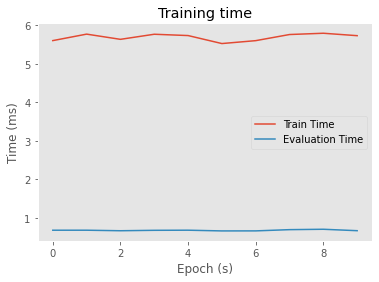

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()

#now create y values for the second plot
y = train_epoch_durations
#calculate the values for the Gaussian curve
x = np.arange(len(train_epoch_durations))
#plot the Gaussian curve
ax.plot(x, y, label = "Train Time")

ax.set(xlabel='Epoch (s)', ylabel='Time (ms)',
       title='Training time')

xe = np.arange(len(eval_epoch_durations))
ye = eval_epoch_durations
#plot sine wave
ax.plot(xe, ye, label = "Evaluation Time")

ax.grid()

#show the legend
plt.legend()
plt.show()

In [ ]:
# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()

#now create y values for the second plot
y = RMS
#calculate the values for the Gaussian curve
x = np.arange(len(RMS))
#plot the Gaussian curve
ax.plot(x, y, label = "Root-mean Square Error")

ax.set(xlabel='Epoch (s)', ylabel='RMSE (%)',
       title='Root-mean Square Error')

ax.grid()

#show the legend
plt.legend()
plt.show()
plt.savefig('img/rmse-ekf.pdf')
plt.savefig('img/rmse-ekf.png')

#### Inference auxiliary method

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import argparse
from matplotlib.pyplot import figure


def showAttention(predictions, attentions):
    output_words = predictions.split()
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,15))
    #figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    ax.set_yticklabels([''] + output_words)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

### Inference

In [ ]:
# Inference
with torch.no_grad():
    for (x, xlens, y) in train_loader:
        predictions, attentions = model(x.cuda(), xlens)
        predictions, attentions = predictions[0], attentions[0]
        predictions = tokenizer.decode(predictions)
        attentions = attentions[:len(predictions.split())].cpu().numpy()   # (target_length, source_length)
        ground_truth = tokenizer.decode(y[0])
        print ("Predict:")
        print (predictions)
        print ("Ground-truth:")
        print (ground_truth)
        print ()
        showAttention(predictions, attentions)

In [ ]:
epoch = 0
with open('config/default/timing.csv', 'w') as filehandle:
    for (train_epoch_duration, eval_epoch_duration, RMSE) in zip(train_epoch_durations, eval_epoch_durations, RMS):
        msg = '%d, %s, %s, %s \n' % (epoch, train_epoch_duration, eval_epoch_duration, RMSE)
        #print(msg)
        epoch = epoch +1 
        filehandle.write(msg)